# Poisson problem and usage of extra-features

### The problem solution 

This tutorial presents how to solve with Physics-Informed Neural Networks for a 2D Poisson problem with Dirichlet boundary conditions.

The problem is written as:
\begin{equation}
\begin{cases}
-\Delta u = -\pi^2\sin{(\pi x)} \sin{(\pi y)} \text{ in } D, \\
u = 0 \text{ on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}
where $D$ is a square domain $[0,1]^2$, and $\Gamma_i$, with $i=1,...,4$, are the boundaries of the square.

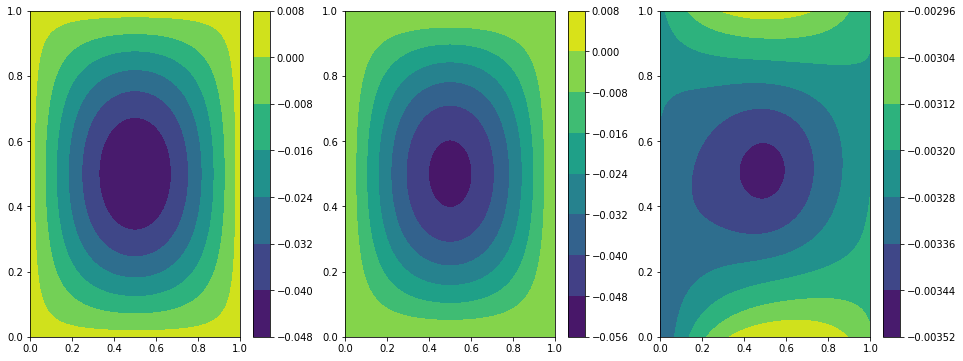

In [1]:
import argparse
import sys
import numpy as np
import torch
from torch.nn import ReLU, Tanh, Softplus


from problem.pinn import PINN
from problem.plotter import Plotter
from problem.label_tensor import LabelTensor
from model.feed_forward import FeedForward

from poisson import Poisson


class myFeature(torch.nn.Module):
    """
    Feature: sin(x)
    """

    def __init__(self):
        super(myFeature, self).__init__()

    def forward(self, x):
        t = (torch.sin(x.extract(['x'])*torch.pi) *
             torch.sin(x.extract(['y'])*torch.pi))
        return LabelTensor(t, ['sin(x)sin(y)'])




feat = [myFeature()] 

poisson_problem = Poisson()
model = FeedForward(
    layers=[64, 64, 64, 64],
    output_variables=poisson_problem.output_variables,
    input_variables=poisson_problem.input_variables,
    func=Softplus,
    extra_features=feat
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pinn = PINN(
    poisson_problem,
    model,
    lr=0.001,
    error_norm='mse',
    regularizer=1e-8,
    device=device,)

pinn.load_state('pinn.poisson')
plotter = Plotter()
plotter.plot(pinn)


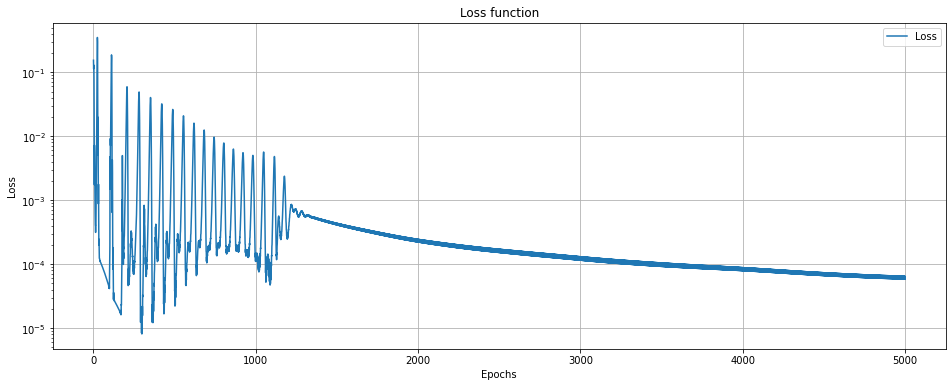

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plotter.plot_loss(pinn, label='Loss')

plt.grid()
plt.legend()
plt.show()